# 基于神经网络的文本相关声纹识别

In [1]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential, model_from_json
from keras.layers import *
from keras import optimizers

warnings.filterwarnings('ignore')

##### 通过路径返回训练音频列表

In [2]:
# -*- coding: utf-8 -*-
def listdir(path: str, list_name: list):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            listdir(file_path, list_name)
        elif os.path.splitext(file_path)[1] == '.wav':
            list_name.append(file_path)
    return list_name

In [3]:
list_name = list()
list_name = listdir('RawData/CASIA database', list_name)

##### 情感分类标签

In [4]:
label_list = list()
for i in range(len(list_name)):
    name = list_name[i]
    if "angry" in name:
        label_list.append("angry")
    elif "fear" in name:
        label_list.append("fear")
    elif "happy" in name:
        label_list.append("happy")
    elif "neutral" in name:
        label_list.append("neutral")
    elif "sad" in name:
        label_list.append("sad")
    elif "surprise" in name:
        label_list.append("surprise")
    else:
        label_list.append("nothing")
labels = pd.DataFrame(label_list)

##### 加载音频文件，并通过MFCC算法分析其特性

In [5]:
df = pd.DataFrame(columns=['feature'])
bookmark = 0
for index, y in enumerate(list_name):
    #音频导入函数
    # X : 音频的信号值，类型是ndarray,sample_rate : 采样率
    # y 音频路径|sr 采样率（默认22050，但是有重采样的功能）
    # duration 获取音频的时长 |offset 音频读取的时间
    # https://www.cnblogs.com/xingshansi/p/6816308.html
    X, sample_rate = librosa.load(y, res_type='kaiser_fast'
                                  , duration=2.5, sr=22050 * 2, offset=0.5)
    #得到采样率
    sample_rate = np.array(sample_rate)
    # MFCC提取：
    # https://www.jianshu.com/p/24044f4c3531
    # 并且求取平均值
    mfccs = np.mean(librosa.feature.mfcc(y=X,
                                         sr=sample_rate,
                                         n_mfcc=13),
                    axis=0)
    #获取音频特征
    feature = mfccs
    df.loc[bookmark] = [feature]
    bookmark = bookmark + 1

##### 将分析的数据作为feature和label相关联

In [6]:
df = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df, labels], axis=1)
rnewdf = shuffle(newdf)
rnewdf = rnewdf.fillna(0)
rnewdf

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
22,2.773206,-1.307503,-5.761493,-4.774549,-10.340865,-4.606022,0.600418,2.328376,-1.005895,-1.168338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
761,-3.124572,-7.044438,-14.995502,-14.869874,-16.752195,-16.599113,-17.550007,-16.249836,-17.463436,-18.098955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
1022,-9.190633,-11.353573,-17.403633,-21.465879,-19.033947,-13.876021,-13.714732,-15.421645,-17.834543,-17.199505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
226,-8.195778,-5.772729,-6.888565,-11.058973,-13.191820,-12.493199,-11.826479,-13.329823,-14.094253,-15.457192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
33,-2.601954,-6.452249,-10.858963,-14.394016,-16.919163,-15.545549,-13.904368,-15.994692,-19.464695,-23.434299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,-22.429386,-23.513510,-24.331617,-25.051685,-25.045017,-24.907808,-24.375624,-23.324474,-18.010513,-7.844188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
337,-7.701246,-11.520564,-17.825970,-19.878010,-23.826769,-25.471651,-24.532169,-24.495121,-21.583321,-19.020922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
80,-19.016932,-15.369948,-13.111642,-10.553329,-11.704426,-15.327604,-15.620792,-15.559501,-17.799173,-19.285042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
18,-1.383584,0.696216,1.549805,-2.323098,-10.815268,-14.704565,-14.887345,-7.623961,-4.929608,-5.906154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry


In [7]:
features = rnewdf.iloc[:, :-1]
labels = rnewdf.iloc[:, -1:]

##### 将数据集分为训练集、验证集和测试集

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.1, shuffle=True,
                                                            random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True,
                                                  random_state=1)

##### 训练与测试音频数：720个训练音频, 240个验证音频，240个测试音频

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(864, 216)
(216, 216)
(120, 216)
(864, 1)
(216, 1)
(120, 1)


##### 转换成numpy数组或矩阵

In [10]:
lb = LabelEncoder()

X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

###### 构造训练模型

In [11]:
model = Sequential()

model.add(Conv1D(256, 5, padding='same', input_shape=(216, 1)))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', ))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', ))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', ))
model.add(BatchNormalizationV1())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 batch_normalization_1 (Batc  (None, 216, 128)         512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

##### 模型训练

In [13]:
cnnhistory = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
7/7 [==============================] - 10s 1s/step - loss: 1.9366 - accuracy: 0.2072 - val_loss: 1.8909 - val_accuracy: 0.1481
Epoch 2/200
7/7 [==============================] - 7s 1s/step - loss: 1.7533 - accuracy: 0.2720 - val_loss: 1.8515 - val_accuracy: 0.1435
Epoch 3/200
7/7 [==============================] - 6s 888ms/step - loss: 1.6571 - accuracy: 0.3183 - val_loss: 1.8222 - val_accuracy: 0.1852
Epoch 4/200
7/7 [==============================] - 6s 905ms/step - loss: 1.5800 - accuracy: 0.3692 - val_loss: 1.7998 - val_accuracy: 0.1944
Epoch 5/200
7/7 [==============================] - 6s 905ms/step - loss: 1.5149 - accuracy: 0.3993 - val_loss: 1.7801 - val_accuracy: 0.2176
Epoch 6/200
7/7 [==============================] - 6s 896ms/step - loss: 1.4502 - accuracy: 0.4433 - val_loss: 1.7693 - val_accuracy: 0.2269
Epoch 7/200
7/7 [==============================] - 6s 900ms/step - loss: 1.3995 - accuracy: 0.4664 - val_loss: 1.7599 - val_accuracy: 0.2407
Epoch 8/200
7/7 [=

##### 绘制模型的损失函数变化曲线

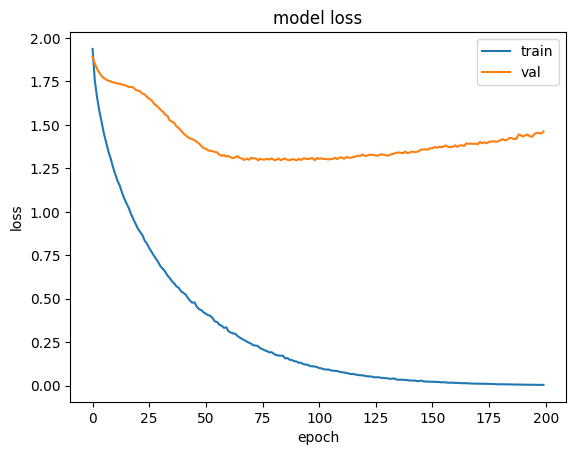

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.savefig("images/loss.png")

##### 绘制模型准确率变化曲线

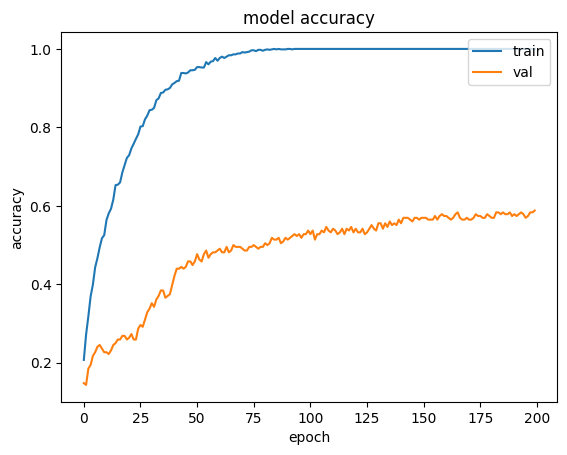

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.savefig("images/accuracy.png")

##### 保存模型结果

In [16]:
model_name = 'model_emotion.h5'
save_dir = os.path.join(os.getcwd(), 'models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
model_json = model.to_json()
with open("models/model_emotion.json", "w") as json_file:
    json_file.write(model_json)

##### 加载模型数据用于测试

In [17]:
json_file = open('models/model_emotion.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/model_emotion.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

Loaded model from disk
accuracy: 61.67%


##### 获取预测结果和真实结果

In [18]:
preds = loaded_model.predict(X_test, batch_size=32, verbose=1)
preds = preds.argmax(axis=1)
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform(preds))
preddf = pd.DataFrame({'predictedvalues': preds})
preddf

4/4 [==============================] - 1s 85ms/step


,predictedvalues
0,sad
1,sad
2,surprise
3,neutral
4,sad
...,...
115,angry
116,happy
117,angry
118,happy


In [19]:
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform(actual))
actualdf = pd.DataFrame({'actualvalues': actual})
actualdf

,actualvalues
0,sad
1,sad
2,surprise
3,sad
4,angry
...,...
115,angry
116,fear
117,angry
118,happy


In [20]:
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,sad,sad
1,sad,sad
2,surprise,surprise
3,sad,neutral
4,angry,sad
...,...,...
115,angry,angry
116,fear,happy
117,angry,angry
118,happy,happy


In [21]:
finaldf.to_csv('result_emotion.csv', index=False)

In [22]:
gc.collect()

8807